# Code Gaussian Process de ChatGPT

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Example user-item interaction matrix (ratings)
# Rows: users, Columns: items
ratings = np.array([
    [5, 4, np.nan, 1],
    [4, np.nan, 5, 2],
    [1, 1, np.nan, 4],
    [np.nan, 5, 4, 5]
])

# Extract observed (non-NaN) user-item pairs and corresponding ratings
user_item_pairs = np.argwhere(~np.isnan(ratings))
observed_ratings = ratings[~np.isnan(ratings)]

# Define kernel for Gaussian Process
# Using RBF (Radial Basis Function) kernel with a constant kernel as prior
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))

# Initialize Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit the model to the observed data
gp.fit(user_item_pairs, observed_ratings)

# Predict ratings for all user-item pairs (with uncertainty)
all_user_item_pairs = np.array([[i, j] for i in range(ratings.shape[0]) for j in range(ratings.shape[1])])
predicted_ratings, std_dev = gp.predict(all_user_item_pairs, return_std=True)

# Reshape predictions to the original ratings matrix shape
predicted_ratings_matrix = predicted_ratings.reshape(ratings.shape)
std_dev_matrix = std_dev.reshape(ratings.shape)

# Print the predicted ratings with uncertainty
print("Predicted Ratings:\n", predicted_ratings_matrix)
print("Uncertainty (Standard Deviation):\n", std_dev_matrix)


Predicted Ratings:
 [[4.99702824 4.00131575 3.52106531 0.99939285]
 [3.99587942 3.5629401  4.99161605 2.00457249]
 [1.00116044 1.00804112 3.2665775  3.9979976 ]
 [3.28382011 4.98932489 4.00433794 4.99484845]]
Uncertainty (Standard Deviation):
 [[0.09988612 0.09991087 1.5757415  0.09991376]
 [0.09986636 1.28915002 0.09988931 0.09981328]
 [0.09987916 0.09987341 1.23495931 0.09985056]
 [1.87701317 0.09987899 0.09986628 0.09987688]]


In [2]:
kernel

1**2 * RBF(length_scale=1)

In [3]:
kernel(user_item_pairs).shape

(12, 12)

In [4]:
kernel(user_item_pairs).round(3)

array([[1.   , 0.607, 0.011, 0.607, 0.082, 0.007, 0.135, 0.082, 0.002,
        0.007, 0.002, 0.   ],
       [0.607, 1.   , 0.135, 0.368, 0.368, 0.082, 0.082, 0.135, 0.018,
        0.011, 0.007, 0.002],
       [0.011, 0.135, 1.   , 0.007, 0.368, 0.607, 0.002, 0.018, 0.135,
        0.002, 0.007, 0.011],
       [0.607, 0.368, 0.007, 1.   , 0.135, 0.011, 0.607, 0.368, 0.007,
        0.082, 0.018, 0.002],
       [0.082, 0.368, 0.368, 0.135, 1.   , 0.607, 0.082, 0.368, 0.368,
        0.082, 0.135, 0.082],
       [0.007, 0.082, 0.607, 0.011, 0.607, 1.   , 0.007, 0.082, 0.607,
        0.018, 0.082, 0.135],
       [0.135, 0.082, 0.002, 0.607, 0.082, 0.007, 1.   , 0.607, 0.011,
        0.368, 0.082, 0.007],
       [0.082, 0.135, 0.018, 0.368, 0.368, 0.082, 0.607, 1.   , 0.135,
        0.607, 0.368, 0.082],
       [0.002, 0.018, 0.135, 0.007, 0.368, 0.607, 0.011, 0.135, 1.   ,
        0.082, 0.368, 0.607],
       [0.007, 0.011, 0.002, 0.082, 0.082, 0.018, 0.368, 0.607, 0.082,
        1.   , 0.607

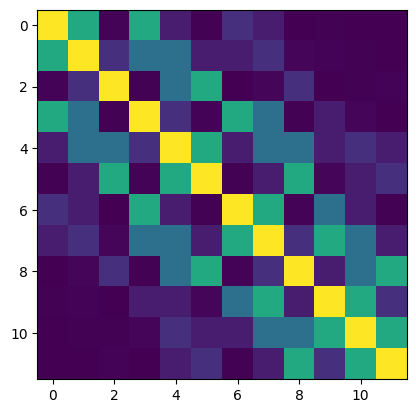

In [5]:
import matplotlib.pyplot as plt
plt.imshow(kernel(user_item_pairs))

In [6]:
user_item_pairs  # Donc la similarité est une exp(-L2) sur les (i, j) considérés comme continus

array([[0, 0],
       [0, 1],
       [0, 3],
       [1, 0],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 3],
       [3, 1],
       [3, 2],
       [3, 3]])

# Test sur Movielens avec baselines Mangaki

## Random folds non striated

In [7]:
import pandas as pd

# df = pd.read_csv('/home/jj/Documents/Mangaki/ratings.csv')
df = pd.read_csv('/home/jj/code/vae/ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
df['user'] = np.unique(df['userId'], return_inverse=True)[1]
df['item'] = np.unique(df['movieId'], return_inverse=True)[1]

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, shuffle=True, random_state=42)

In [10]:
from zero.knn import MangakiKNN

knn = MangakiKNN()
knn.nb_users = df['user'].nunique()
knn.nb_works = df['item'].nunique()
knn.fit(df_train[['user', 'item']].values, df_train['rating'])

In [11]:
y_pred = knn.predict(df_test[['user', 'item']].values)

In [12]:
y_test = df_test['rating'].values

In [13]:
((y_pred - y_test) ** 2).mean() ** 0.5

2.240636102627217

KNN obtient une RMSE de 2,24 donc autant dire qu'elle est terrible

In [14]:
from zero.svd import MangakiSVD

svd = MangakiSVD()
svd.nb_users = df['user'].nunique()
svd.nb_works = df['item'].nunique()
svd.fit(df_train[['user', 'item']].values, df_train['rating'])

Computing M: (610 × 9724)
Shapes (610, 20) (20,) (20, 9724)


In [15]:
y_pred = svd.predict(df_test[['user', 'item']].values)

In [16]:
((y_pred - y_test) ** 2).mean() ** 0.5

0.9172088437758473

SVD est une meilleure baseline, RMSE de 0.917

## Striated folds: train and test on 50% of a single user

Pour être précis : on suppose que toutes les données sauf user 94 sont le training set.  
Puis on entraîne le GP sur 50 % des ratings de user 94 (validation), et on teste sur 50 % restants de user 94 (test).

In [17]:
from random import choice

# choice(df['user'].unique())  # Was 94

In [18]:
df.query("user == 94").shape  # User 94 a noté 168 œuvres

(168, 6)

In [19]:
training = df.query("user != 94")
valtest = df.query("user == 94")

In [20]:
valtest.shape

(168, 6)

In [21]:
val, test = train_test_split(valtest, shuffle=True, test_size=0.5, random_state=42)

In [22]:
val.shape, test.shape

((84, 6), (84, 6))

In [23]:
trainval = pd.concat((training, valtest))
trainval.shape

(100836, 6)

In [24]:
training.shape

(100668, 6)

In [25]:
knn = MangakiKNN()
knn.nb_users = df['user'].nunique()
knn.nb_works = df['item'].nunique()
knn.fit(trainval[['user', 'item']].values, trainval['rating'])

In [26]:
y_pred = knn.predict(test[['user', 'item']].values)
y_test = test['rating'].values

In [27]:
((y_pred - y_test) ** 2).mean() ** 0.5

1.6755422112521572

Baseline terrible KNN : RMSE 1.675 sur 50 % de user 94

In [28]:
svd = MangakiSVD()
svd.nb_users = df['user'].nunique()
svd.nb_works = df['item'].nunique()
svd.fit(trainval[['user', 'item']].values, trainval['rating'])

Computing M: (610 × 9724)
Shapes (610, 20) (20,) (20, 9724)


y_pred = svd.predict(test[['user', 'item']].values)
((y_pred - y_test) ** 2).mean() ** 0.5

Baseline SVD : RMSE 0.841 sur 50 % de user 94

In [29]:
svd.VT.T.shape

(9724, 20)

In [30]:
from scipy.sparse import csr_matrix

M = csr_matrix((training['rating'], (training['user'], training['item'])))
M

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100668 stored elements in Compressed Sparse Row format>

In [31]:
from sklearn.gaussian_process.kernels import DotProduct, RBF, ConstantKernel as C

kernel = DotProduct(1.0, (1e-3, 1e3))
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
# kernel = RBF(1.0, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

In [32]:
M.T[val['item']]

<84x610 sparse matrix of type '<class 'numpy.float64'>'
	with 4630 stored elements in Compressed Sparse Column format>

In [33]:
gp.fit(M.T[val['item']].toarray(), val['rating'])

GaussianProcessRegressor(alpha=0.01, kernel=DotProduct(sigma_0=1),
                         n_restarts_optimizer=10)

In [34]:
y_pred = gp.predict(M.T[test['item']].toarray())
((y_pred - y_test) ** 2).mean() ** 0.5

1.0087392850114103

GP avec linear kernel : RMSE 1.009 si j'utilise comme embeddings les notes données aux items du validation set

Ainsi ce modèle-là n'est entraîné °que° sur les films du validation de user 94 ; on tronque les autres films, ils n'existent pas ici

Devrait avoir une performance similaire à KNN (sur les tests ici, c'est systématiquement mieux)

In [35]:
gp.fit(svd.VT.T[val['item']], val['rating'])

y_pred, y_std = gp.predict(svd.VT.T[test['item']], return_std=True)
((y_pred - y_test) ** 2).mean() ** 0.5

0.7785755707809213

GP avec linear kernel : RMSE 0.779 si j'utilise les embeddings appris par SVD (factorisation de la matrice de ratings) donc entraîné sur tout le training

En pratique un peu moins bon que SVD (qui lui fait un preprocessing supplémentaire où il retire la note moyenne des users et des items), pour cet exemple-ci un peu meilleur

In [36]:
pd.set_option('display.max_rows', None)

pd.DataFrame(np.column_stack((y_pred, y_std, y_test)), columns=('pred', 'std', 'true')).sort_values('pred')

,pred,std,true
8,3.202886,0.046777,3.0
69,3.398228,0.050602,2.0
28,3.412264,0.063595,4.0
17,3.526573,0.037060,1.0
72,3.554957,0.069490,4.0
81,3.577187,0.034891,4.0
4,3.600225,0.050048,4.5
38,3.689672,0.043732,4.0
26,3.708114,0.035042,2.0
61,3.738374,0.063425,5.0


Les mauvaises notes sont plutôt en haut et les bonnes notes plutôt en bas : c'est cohérent